<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn.apionly as sns
import pcmdpy as ppy
import warnings
%matplotlib inline

GPU acceleration enabled


In [2]:
# sns.set_context('poster')

In [2]:
ppy.gpu_utils.initialize_gpu(n=0)

using given n: 0
Starting SourceModule Code
Getting function
Past the SourceModule code
CUDAC Available
Starting Kernel Code
Getting Kernel function
Past the Kernel code


In [3]:
f = ppy.instrument.m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)

In [4]:
driv = ppy.driver.Driver(iso_model, gpu=True)

In [5]:
g1 = ppy.galaxy.TauModel(np.array([-0.2, -2., 2., 5.]))
g2 = ppy.galaxy.TauModel(np.array([-0.52, -1.08, 1.96, 6.4]))
g3 = ppy.galaxy.TauModelMDF(np.array([-0.2, 0.5, -2., 2., 5]))

In [6]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
print('1')
pcmd1, _ = driv.simulate(g1, 1024, fixed_seed=True)
print('2')
pcmd2, _ = driv.simulate(g2, 1024, fixed_seed=True)
print('3')
pcmd3, _ = driv.simulate(g3, 1024, fixed_seed=True)

1
2
3


In [8]:
g_blah = ppy.galaxy.SSPModel(np.array([-0.2, -2., 2., 10.]))

In [67]:
def my_err(counts):
    emin = 2.
    err = np.sqrt(counts)
    err += emin * np.exp(-err)
    return err

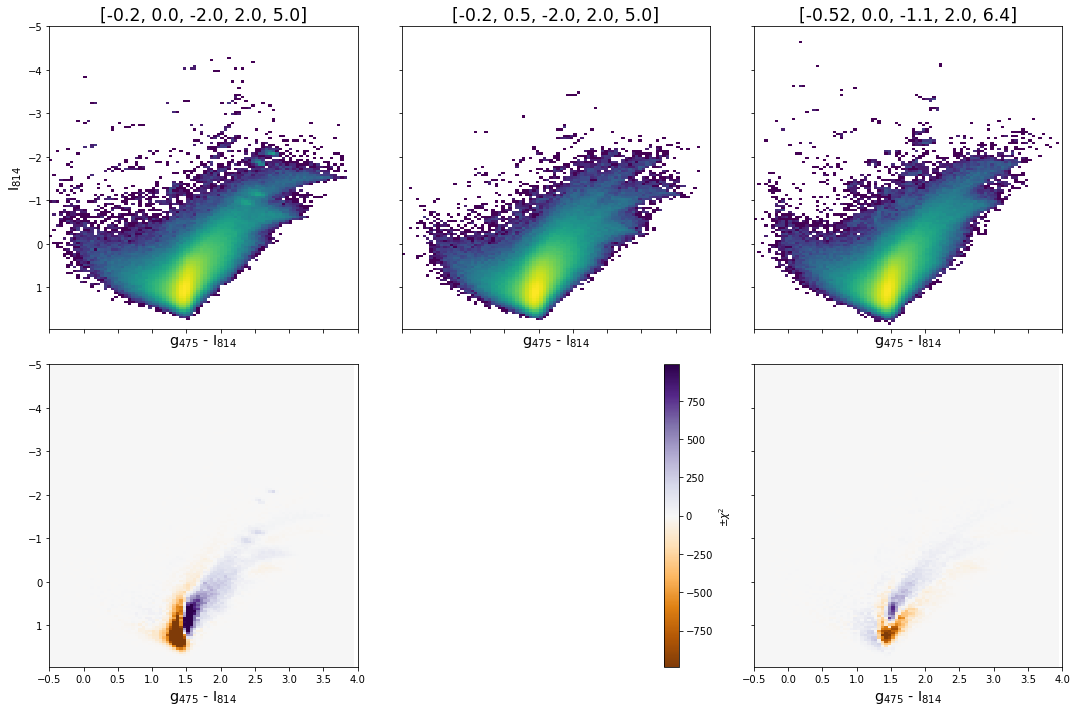

In [71]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10), sharex=True, sharey=True)
n = mpl.colors.LogNorm()
b = [np.arange(-0.5, 4.0, 0.05), np.arange(-5., 2., .05)]
# compute correct PCMD
counts3, xb, yb, _ = axes[0,1].hist2d(pcmd3[1], pcmd3[0], norm=n, cmap='viridis', bins=b, label=r'$\mu = -0.2, \sigma = 0.5$')
axes[0,1].set_title('[-0.2, 0.5, -2.0, 2.0, 5.0]', fontsize='xx-large')
# compute others, to subtract
counts1, _, _, _ = axes[0,0].hist2d(pcmd1[1], pcmd1[0], norm=n, cmap='viridis', bins=b)
counts2, _, _, _ = axes[0,2].hist2d(pcmd2[1], pcmd2[0], norm=n, cmap='viridis', bins=b)
dc1 = (counts1 - counts3)
sign1 = np.sign(dc1)
chi2_1 = sign1 * (dc1**2. / (my_err(counts1)**2 + my_err(counts3)**2))
dc2 = (counts2 - counts3)
sign2 = np.sign(dc2)
chi2_2 = sign1 * (dc2**2. / (my_err(counts2)**2 + my_err(counts3)**2))
vm = max(np.abs(chi2_1).max(), np.abs(chi2_2).max())
n2 = mpl.colors.Normalize(vmin=-vm, vmax=vm)
axes[1,0].imshow((counts1 - counts3).T, extent=[xb[0], xb[-1], yb[-1], yb[0]], cmap='PuOr', norm=n2, aspect='auto')
axes[0,0].set_title('[-0.2, 0.0, -2.0, 2.0, 5.0]', fontsize='xx-large')
#
plt.subplot(axes[1,2])
plt.imshow((counts2 - counts3).T, extent=[xb[0], xb[-1], yb[-1], yb[0]], cmap='PuOr', norm=n2, aspect='auto')
axes[0,2].set_title('[-0.52, 0.0, -1.1, 2.0, 6.4]', fontsize='xx-large')
axes[0,0].set_ylabel(r'I$_{814}$', fontsize='x-large')
yl = axes[0,0].get_ylim()
axes[0,0].set_ylim([max(yl), min(yl)])
axes[0,0].set_xlim([-0.5, 4.0])
plt.colorbar(ax=axes[1,1], label=r'$\pm \chi^2$')
for ax in axes.flatten():
    iso_model.plot_isochrone(g_blah, axes=ax, lw=0)
axes[1,1].axis('off')
plt.tight_layout()
plt.savefig('figures/mdf_compare.pdf')